In [1]:
import torch
from torch import optim
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
from matplotlib import pyplot as plt
import models
from tqdm.notebook import tqdm

In [2]:
trace_head = "./results/traces"
fn_list = os.listdir(trace_head)
print(fn_list)

['saved_A_1622586201.1394565.pt', 'saved_A_1622588934.2849271.pt', 'saved_A_1622590543.5536091.pt', 'saved_A_1622590543.553758.pt', 'saved_A_1622590543.55377.pt', 'saved_A_1622590543.5538652.pt', 'saved_A_1622590546.2475152.pt', 'saved_A_1622590873.7518249.pt', 'saved_A_1622592009.025987.pt', 'saved_A_1622592814.259459.pt', 'saved_B_1622586201.1394565.pt', 'saved_B_1622588934.2849271.pt', 'saved_B_1622590543.5536091.pt', 'saved_B_1622590543.553758.pt', 'saved_B_1622590543.55377.pt', 'saved_B_1622590543.5538652.pt', 'saved_B_1622590546.2475152.pt', 'saved_B_1622590873.7518249.pt', 'saved_B_1622592009.025987.pt', 'saved_B_1622592814.259459.pt']


In [3]:
def GetSecond():
    optimizer.zero_grad()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # images = images.view(-1, 784)
        outputs, outputsS = model(images)
        loss = criteria(outputs, outputsS,labels)
        loss.backward()

BS = 128

trainset = torchvision.datasets.MNIST(root='~/Private/data', train=True,
                                    download=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                        shuffle=True, num_workers=2)

In [4]:
device = torch.device("cuda:0")
total_S_list= []

for fn in tqdm(fn_list):
    this_S_list = []
    model = models.SMLP4()
    state_dict = torch.load(trace_head + "/" + fn, map_location="cpu")
    model.load_state_dict(state_dict)
    model.to(device)
    model.push_S_device()
    model.clear_noise()
    model.clear_mask()
    criteria = models.SCrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    GetSecond()
    layers = [model.fc1, model.fc2, model.fc3, model.fc4]
    for l in layers:
        data = l.weightS.grad.data.cpu().numpy().reshape(-1)
        this_S_list.append(data.sum())
    total_S_list.append(this_S_list)
    

In [5]:
total_S_list = np.array(total_S_list)
print(total_S_list.shape)
print(total_S_list.sum(axis=1)/1e8)

(20, 4)
[0.43269372 0.36541167 1.0609965  0.56987166 0.6211234  0.41989705
 0.54375845 0.5237681  0.77886546 0.24981461 0.44963413 0.3898509
 1.097871   0.60728    0.6166732  0.44032893 0.5724962  0.57700557
 0.80879825 0.23211914]


In [8]:
T = [0.9489, 0.9459, 0.9296, 0.9409, 0.9527, 0.9488, 0.9282, 0.9436, 0.9495, 0.9537,
 0.9495, 0.9436, 0.9244, 0.9385, 0.9528, 0.9466, 0.9263, 0.9388, 0.9488, 0.9547]

(0.92, 0.97)

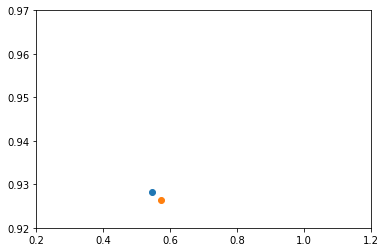

In [24]:
st = 6
plt.scatter((total_S_list.sum(axis=1)/1e8)[st:st+1], T[st:st+1])
plt.scatter((total_S_list.sum(axis=1)/1e8)[st+10:st+11], T[st+10:st+11])
plt.xlim(0.2,1.2)
plt.ylim(0.92,0.97)

Text(0.5, 0, 'Sum of Second Derivative (1e8)')

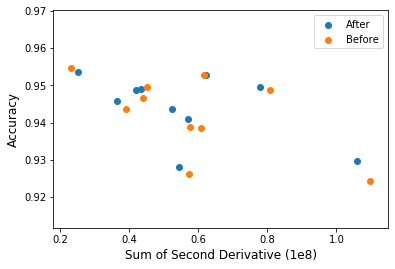

In [15]:

plt.scatter((total_S_list.sum(axis=1)/1e8)[:10], T[:10])
plt.scatter((total_S_list.sum(axis=1)/1e8)[10:], T[10:])
# plt.scatter((total_S_list.sum(axis=1)/1e8)[:], T[:])
plt.legend(["After", "Before"])
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Sum of Second Derivative (1e8)", fontsize=12)

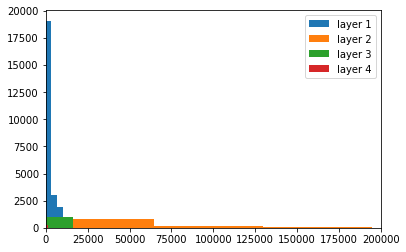

In [12]:
for l in layers:
    data = l.weightS.grad.data.cpu().numpy().reshape(-1)
    plt.hist(data)
plt.xlim([0,200000])
plt.legend(["layer 1", "layer 2", "layer 3", "layer 4"])

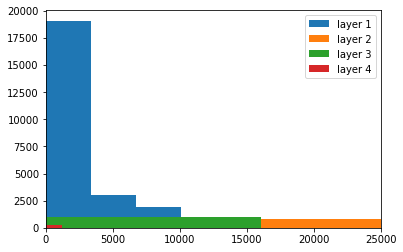

In [14]:
for l in layers:
    data = l.weightS.grad.data.cpu().numpy().reshape(-1)
    plt.hist(data)
plt.xlim([0,25000])
plt.legend(["layer 1", "layer 2", "layer 3", "layer 4"])

In [13]:
data = layers[1].weightS.grad.data.cpu().numpy().reshape(-1)
size = len(data)
the_max = data.max()
print(the_max)
(data > 200000).sum() / size

649182.2


0.03515625